In [1]:
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

Using TensorFlow backend.


In [2]:
import cv2

from scipy.misc import imresize
from skimage.transform import resize

import glob

import matplotlib.pyplot as plt
%matplotlib inline

from keras.callbacks import EarlyStopping

In [3]:
def ab_block9(a,b):
    h,w = a.shape
    y = np.zeros((h,w))
    Llim = 120
    Hlim = 130
    for i in range(h):
        for j in range(w):
            ai = a[i,j]
            bi = b[i,j]
            if ai<Llim:
                if bi<Llim:
                    y[i,j] = 0
                elif bi>Hlim:
                    y[i,j] = 1
                else:
                    y[i,j] = 2
            elif ai>Hlim:
                if bi<Llim:
                    y[i,j] = 3
                elif bi>Hlim:
                    y[i,j] = 4
                else:
                    y[i,j] = 5
            else:
                if bi<Llim:
                    y[i,j] = 6
                elif bi>Hlim:
                    y[i,j] = 7
                else:
                    y[i,j] = 8
    return y

In [68]:
def block9_img(x,y):
    h,w = y.shape
    a = np.zeros((h,w))
    b = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            yi = y[i,j]
            if 0<yi<=0.5: 
                a[i,j] = 50
                b[i,j] = 50
            elif 0.5<yi<=1.5:
                a[i,j] = 50
                b[i,j] = 200
            elif 1.5<yi<=2.5:
                a[i,j] = 50
                b[i,j] = 125
            elif 2.5<yi<=3.5:
                a[i,j] = 200
                b[i,j] = 50
            elif 3.5<yi<=4.5: 
                a[i,j] = 200
                b[i,j] = 200
            elif 5.5<yi<=6.5: 
                a[i,j] = 200
                b[i,j] = 125
            elif 6.5<yi<=7.5:
                a[i,j] = 125
                b[i,j] = 50
            elif 7.5<yi<=8.5: 
                a[i,j] = 125
                b[i,j] = 200
            else:
                a[i,j] = 127
                b[i,j] =127
    img_lab = np.zeros((h,w,3))
    img_lab[:,:,0] = x
    img_lab[:,:,1] = a
    img_lab[:,:,2] = b
    img = cv2.cvtColor(img_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)
    return img

In [19]:
# read images and split a b
img_all = []
X = []
Y = []
for img in glob.glob(r"../../images/*.jpg"):
    n= cv2.imread(img)#BGR
    if not n is None and np.mean(n)<250 and np.mean(np.std(n,axis=2))>2:
    # drop None pic, almost white pic, almost gray scale pic
        m = imresize(n,(400,400,3))
        img_lab = cv2.cvtColor(m.astype(np.uint8), cv2.COLOR_BGR2LAB)
        L = img_lab[:,:,0]
        a = img_lab[:,:,1]
        b = img_lab[:,:,2]
        img_all.append(m)
        y = ab_block9(a,b)
        L = L.reshape(1, 400, 400, 1)
        y = y.reshape(1, 400, 400, 1) 
        Y.append(y)
        X.append(L)

In [21]:
X=np.array(X)
Y=np.array(Y)

In [25]:
X.shape

(20, 400, 400, 1)

In [24]:
num = 20
X=np.reshape(X, (num, 400, 400, 1))
Y=np.reshape(Y, (num, 400, 400, 1))

In [55]:
# Building the neural network 九层神经网络 跑一次就行了
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation='relu', padding='same'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, None, None, 8)     80        
_________________________________________________________________
conv2d_40 (Conv2D)           (None, None, None, 8)     584       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_42 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_44 (Conv2D)           (None, None, None, 32)    9248      
__________

In [56]:
# Finish model
model.compile(optimizer='adam',loss='mse')

In [61]:
# 5 mins 823pm-31; 209-
model.fit(x=X, 
    y=Y,
    batch_size=2,
    epochs=10, callbacks=[EarlyStopping(patience=5)])

Epoch 1/10
20/20 [==============================] - 30s 1s/step - loss: 8.9977
Epoch 2/10


C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:526: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


20/20 [==============================] - 32s 2s/step - loss: 8.3471
Epoch 3/10
20/20 [==============================] - 36s 2s/step - loss: 8.5972
Epoch 4/10
20/20 [==============================] - 31s 2s/step - loss: 8.3469
Epoch 5/10
20/20 [==============================] - 34s 2s/step - loss: 8.2364
Epoch 6/10
20/20 [==============================] - 29s 1s/step - loss: 7.9964
Epoch 7/10
20/20 [==============================] - 31s 2s/step - loss: 7.7537
Epoch 8/10
20/20 [==============================] - 32s 2s/step - loss: 7.6505
Epoch 9/10
20/20 [==============================] - 34s 2s/step - loss: 8.1058
Epoch 10/10
20/20 [==============================] - 31s 2s/step - loss: 8.4044


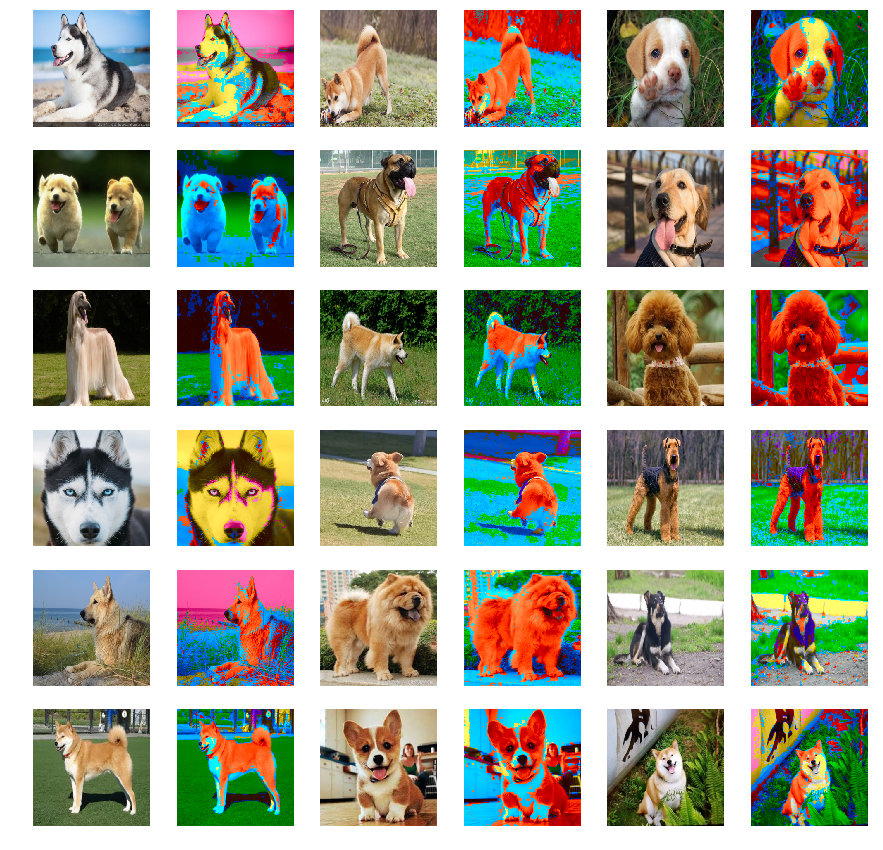

In [77]:
# reconstuction
j =1
plt.figure(figsize=(15,15))
for i in range(18):
    plt.subplot(6,6,j)
    j += 1
    plt.imshow(cv2.cvtColor(img_all[i],cv2.COLOR_BGR2RGB))
    plt.axis('OFF')
    plt.subplot(6,6,j)
    j += 1
    img_re = block9_img(X[i,:,:,0],Y[i,:,:,0])
    plt.imshow(img_re)
    plt.axis('OFF')

In [71]:
imgts =img_all[10]
Yhat = model.predict(X[10:11])

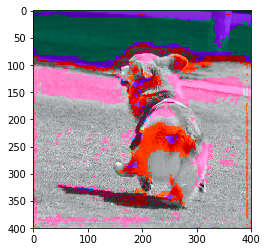

In [72]:
imgts_re = block9_img(X[10,:,:,0],Yhat[0,:,:,0])
plt.imshow(imgts_re)

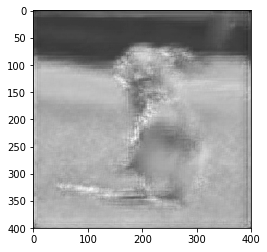

In [74]:
plt.imshow(Yhat[0,:,:,0],'gray')

In [66]:
Yhat[0,:,:,0].min()

0.43025765

In [67]:
Yhat[0,:,:,0].max()

9.3228855